In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from itertools import groupby
from datetime import datetime, timedelta
from tensorflow import keras
from sklearn import metrics
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

In [3]:
full_data = pd.read_csv("/content/drive/MyDrive/Anti/CPU_616.csv")
full_data = full_data.reset_index(drop=True)
full_data

,Example id,vm_id,cpu_used,diskio_read,diskio_write,created_at
0,24326126,616,0.2%,172301913,345089311,1/1/22 12:00 AM
1,24326382,616,0.2%,172310525,345101743,1/1/22 12:05 AM
2,24326638,616,0.19%,172310525,345106715,1/1/22 12:10 AM
3,24326894,616,0.2%,172310677,345112455,1/1/22 12:15 AM
4,24327150,616,0.2%,172310693,345117407,1/1/22 12:20 AM
...,...,...,...,...,...,...
140348,65165183,616,6.85%,45594927,165928340,5/4/23 3:05 AM
140349,65165493,616,7.43%,45594927,165934556,5/4/23 3:10 AM
140350,65165803,616,7.73%,45594951,165941400,5/4/23 3:15 AM
140351,65166113,616,7.24%,45594983,165948480,5/4/23 3:20 AM


In [4]:
# Converting CPU Usage to Float Datatype

full_data['cpu_used'] = (full_data['cpu_used'].str.replace('%', '').astype(float)) / 100
full_data = full_data[["created_at", "cpu_used"]]
full_data

,created_at,cpu_used
0,1/1/22 12:00 AM,0.0020
1,1/1/22 12:05 AM,0.0020
2,1/1/22 12:10 AM,0.0019
3,1/1/22 12:15 AM,0.0020
4,1/1/22 12:20 AM,0.0020
...,...,...
140348,5/4/23 3:05 AM,0.0685
140349,5/4/23 3:10 AM,0.0743
140350,5/4/23 3:15 AM,0.0773
140351,5/4/23 3:20 AM,0.0724


In [5]:
full_data.isnull().sum()

created_at    0
cpu_used      0
dtype: int64

In [6]:
full_data['created_at'] = pd.to_datetime(full_data['created_at'])

In [7]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140353 entries, 0 to 140352
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   created_at  140353 non-null  datetime64[ns]
 1   cpu_used    140353 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.1 MB


In [8]:
full_data.describe().T

,count,mean,std,min,25%,50%,75%,max
cpu_used,140353.0,0.083155,0.052075,0.0,0.0638,0.0723,0.0985,1.0878


### Train-Test Split

In [9]:
# Splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(full_data.iloc[:, :-1], full_data.iloc[:, -1], 
                                                    test_size=0.2, shuffle=False)

# Checking dataset splitting result
print(f"Training data: {len(x_train)} data")
print(f"Validation data: {len(x_test)} data")

Training data: 112282 data
Validation data: 28071 data


In [10]:
y_train

0         0.0020
1         0.0020
2         0.0019
3         0.0020
4         0.0020
           ...  
112277    0.0599
112278    0.0574
112279    0.0594
112280    0.0592
112281    0.0592
Name: cpu_used, Length: 112282, dtype: float64

### Modeling: ARIMA Univariate Time Series Forecasting

#### Visualizing Preprocessed CPU Usage Variable

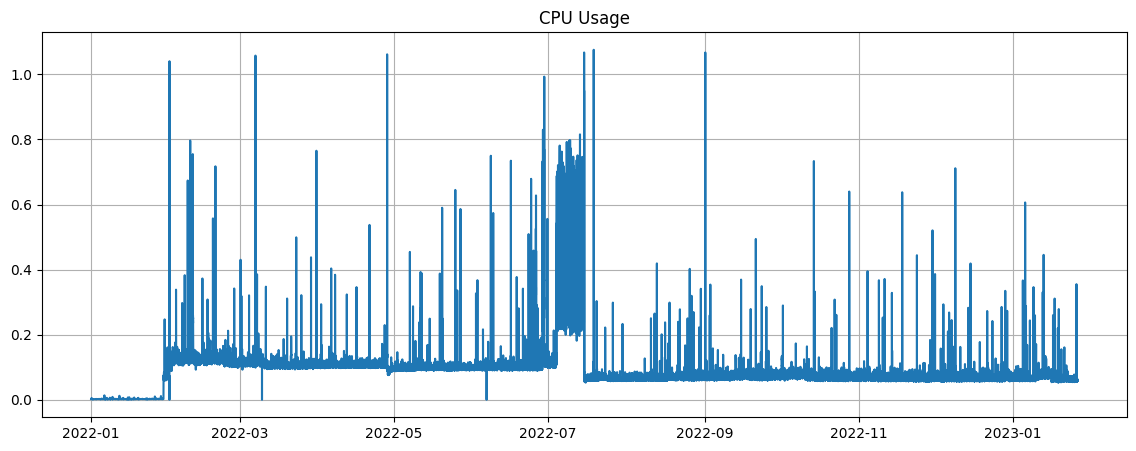

In [11]:
fig, (ax1) = plt.subplots(1,figsize=(14,5))
plt.title('CPU Usage')
# ax1.plot(y_train.index.to_numpy(), y_train)
ax1.plot(x_train, y_train)
plt.grid()

#### Stationarity Test

In [12]:
from statsmodels.tsa.stattools import adfuller

def adfullertest(data):
    result = adfuller(data)
    print(f'ADF Statistics: {result[0]}')
    print(f'p-Value: {result[1]}')
    if result[1] < 0.05:
        print('Stationary')
    else:
        print('Non-Stationary')

Augmented Dickey-Fuller (ADF test) merupakan pengujian statistik untuk mengukur stationarity data. Pengujian ini memiliki hipotesis nol (H0) bahwa data tidak stasioner. Umumnya jika p-value < 0.05, maka dianggap telah cukup bukti untuk menolak H0 dan menerima H1 bahwa data telah memiliki sifat stasioner.

In [13]:
adfullertest(y_train)

ADF Statistics: -6.152189010007072
p-Value: 7.515677911141271e-08
Stationary


Hasil ADF Test menunjukkan p-value > 0.05. Dari nilai ini dapat ditarik kesimpulan bahwa data masih sangat jauh dari sifat stasioner untuk dapat dijadikan sebagai input ARIMA. Untuk itu, akan digunakan teknik differencing untuk menghilangkan trend dari data dan sekaligus membuat data menjadi lebih stasioner.

#### Differencing Technique

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA

#### Data Asli

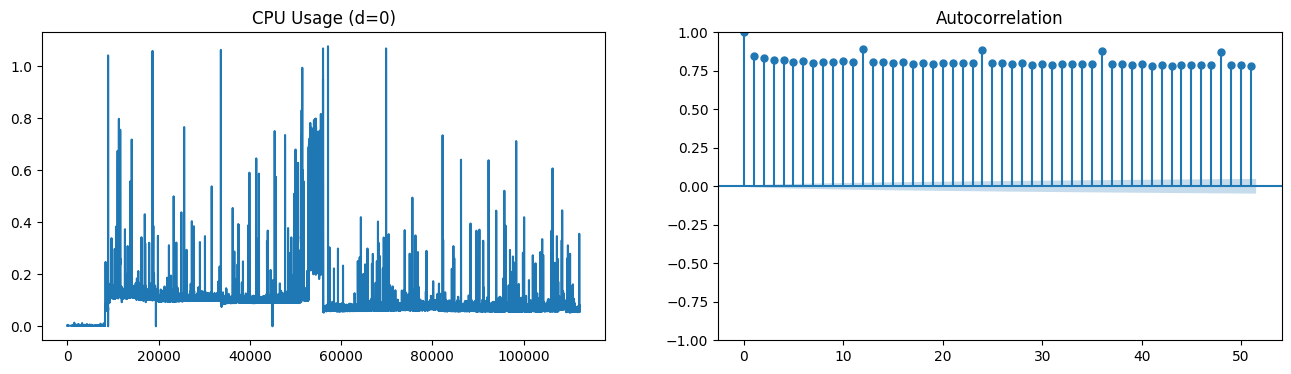

In [15]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(y_train)
ax1.set_title('CPU Usage (d=0)')
plot_acf(y_train, ax=ax2);

Dari visualisasi, mudah terlihat bahwa data asli sudah sangat stasioner.

#### First Order Differencing (d=1)

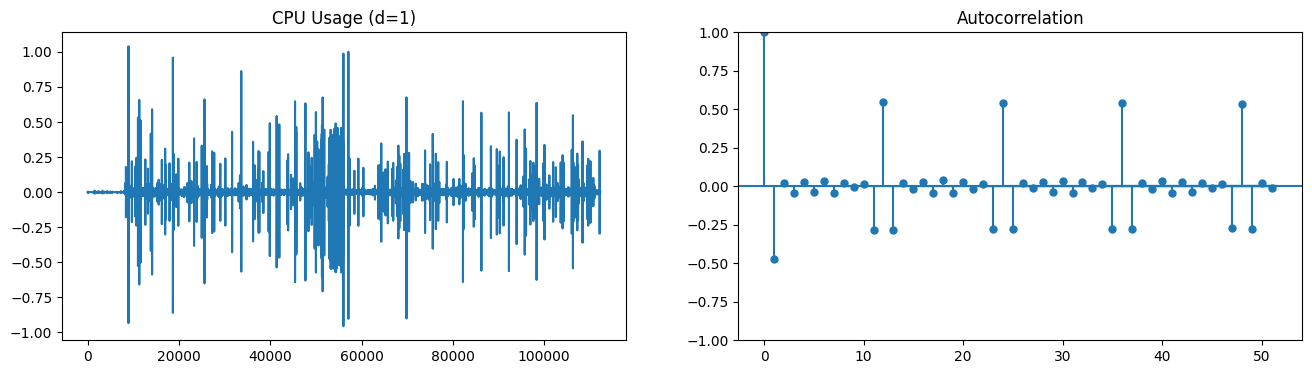

In [16]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(y_train.diff().dropna())
ax1.set_title('CPU Usage (d=1)')
plot_acf(y_train.diff().dropna(), ax=ax2);

#### Second Order Differencing (d=2)

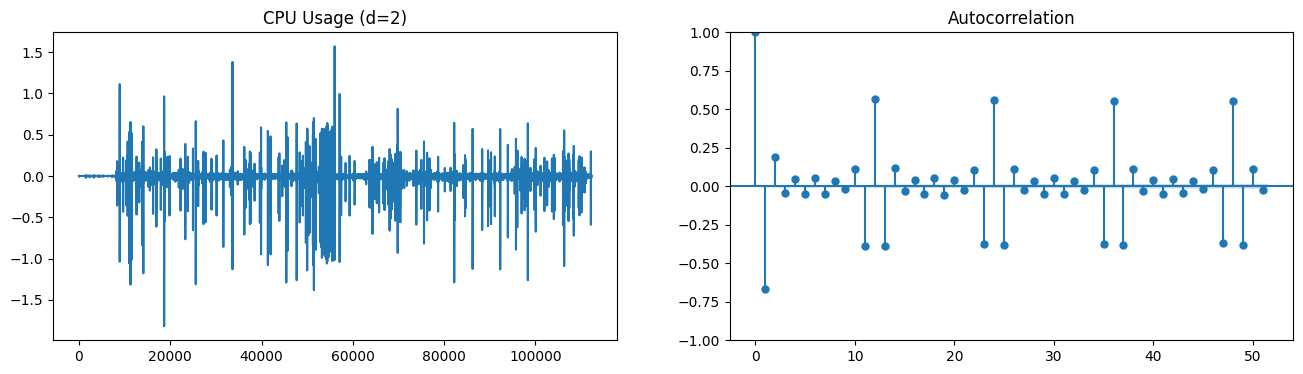

In [17]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(y_train.diff().diff().dropna())
ax1.set_title('CPU Usage (d=2)')
plot_acf(y_train.diff().diff().dropna(), ax=ax2);

#### Autoregression (AR) Parameter

Parameter Autoregression (p) pada ARIMA merupakan jumlah lags yang digunakan ARIMA untuk melakukan prediksi. Dengan kata lain, parameter ini menunjukkan seberapa jauh ARIMA akan meihat past values untuk melakukan prediksi terhadap data baru. Untuk menentukannya dapat digunakan analisis Partial Autocorrelation Function (PACF).

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


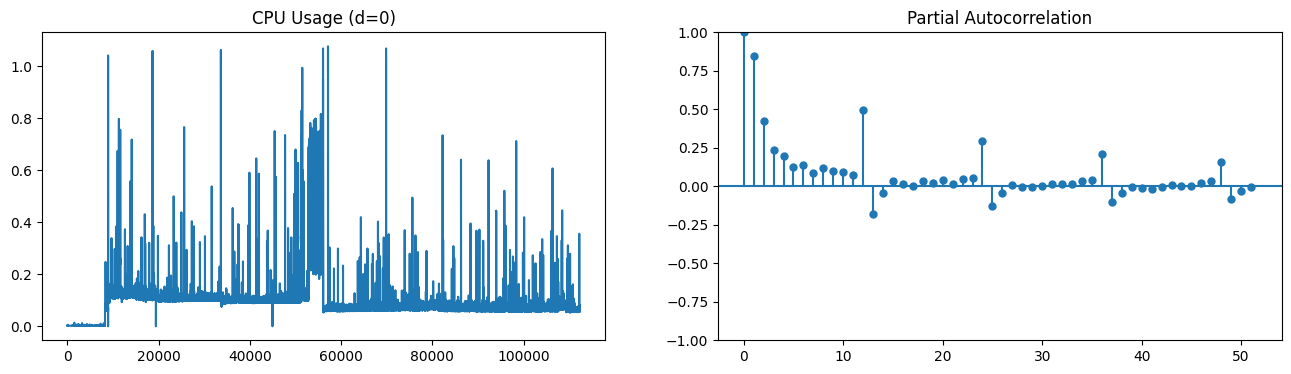

In [18]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(y_train.dropna())
ax1.set_title('CPU Usage (d=0)')
plot_pacf(y_train.dropna(), ax=ax2);

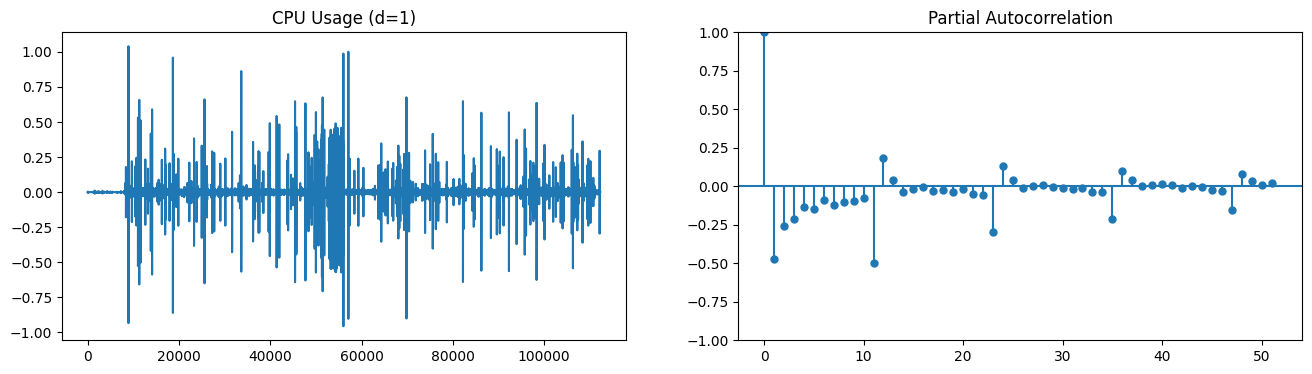

In [19]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(y_train.diff().dropna())
ax1.set_title('CPU Usage (d=1)')
plot_pacf(y_train.diff().dropna(), ax=ax2);

#### Moving Average (MA) Parameter

Parameter Moving Average (q) pada ARIMA menunjukkan seberapa jauh error lags yang dipertimbangkan untuk melakukan prediksi. Parameter ini dapat ditentukan dengan menggunakan analisis Autocorrelation Function (ACF).

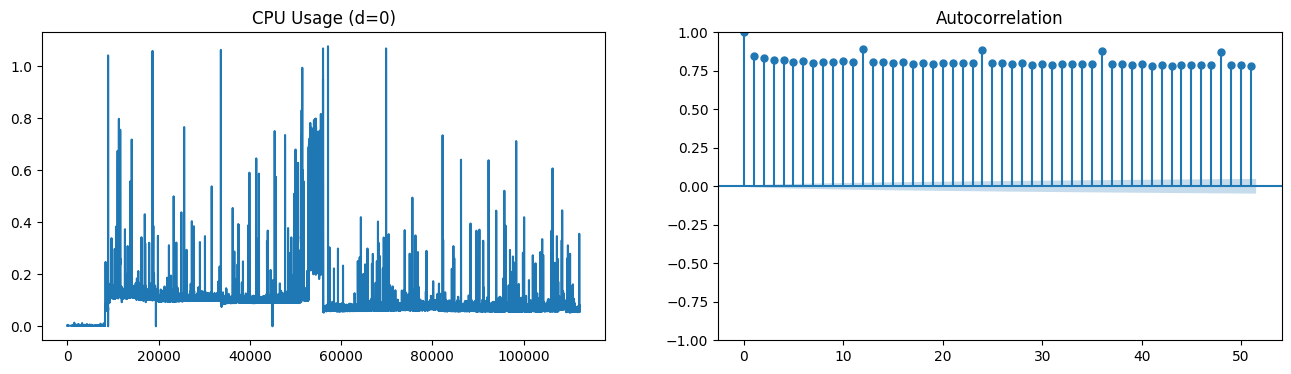

In [20]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(y_train.dropna())
ax1.set_title('CPU Usage (d=0)')
plot_acf(y_train.dropna(), ax=ax2);

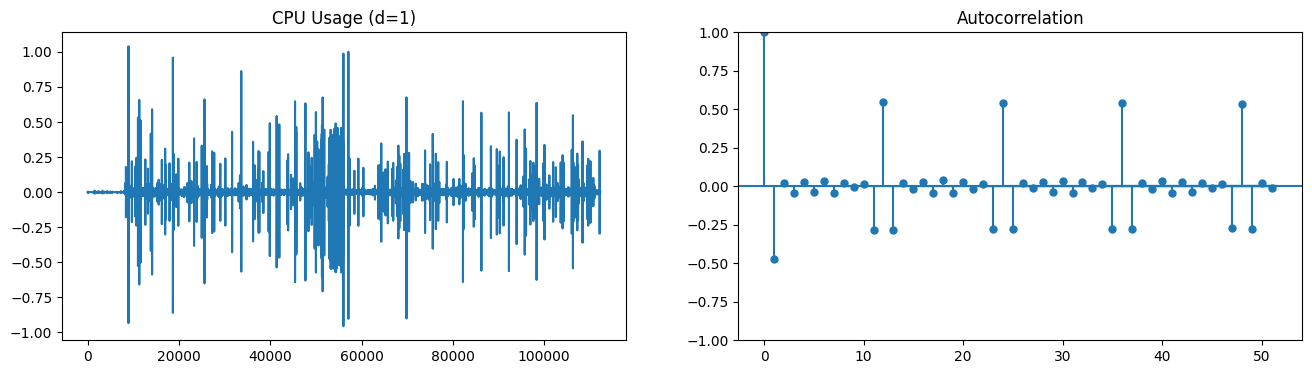

In [21]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(y_train.diff().dropna())
ax1.set_title('CPU Usage (d=1)')
plot_acf(y_train.diff().dropna(), ax=ax2);

### ARIMA Model Hyperparameter Tuning

In [22]:
# Model Evaluation Functions
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(df_train_y, df_test_y, arima_order):
    # Prepare training dataset
    train_size = int(len(df_train_y))
    test_size = int(len(df_test_y))
    train, test = df_train_y, df_test_y
    # Make predictions
    model = ARIMA(df_train_y, order=arima_order)
    model_fit = model.fit()
    predictions = model_fit.forecast(test_size)
    # Calculate out of sample error
    rmse = (mean_squared_error(test, predictions))**0.5
    mae = mean_absolute_error(test, predictions)
    return rmse, mae
 
# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(df_train_y, df_test_y, p_values, d_values, q_values):
    best_score, best_cfg, best_mae = float("inf"), None, float("inf")
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse, mae = evaluate_arima_model(df_train_y, df_test_y, order)
                    if rmse < best_score:
                        best_score, best_cfg, best_mae = rmse, order, mae
                    print('ARIMA%s RMSE=%.3f MAE=%.3f' % (order,rmse,mae))
                except:
                    continue
    print('Best ARIMA %s RMSE = %.3f MAE = %.3f' % (best_cfg, best_score, best_mae))

In [ ]:
# # HATI-HATI LAMA

# import warnings
# warnings.filterwarnings("ignore")

# Evaluate parameters
p_values = [1, 2]
d_values = [0, 1]
q_values = [1, 2]

evaluate_models(y_train, y_test, p_values, d_values, q_values)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1) RMSE=0.028 MAE=0.019


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2) RMSE=0.029 MAE=0.020
ARIMA(1, 1, 1) RMSE=0.024 MAE=0.010


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) RMSE=0.024 MAE=0.010


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1) RMSE=0.025 MAE=0.013


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) RMSE=0.054 MAE=0.050
ARIMA(2, 1, 1) RMSE=0.024 MAE=0.010


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) RMSE=0.024 MAE=0.010
Best ARIMA (1, 1, 2) RMSE = 0.024 MAE = 0.010


#### Forecasting Future Values of CPU Usage

In [23]:
model = ARIMA(full_data['cpu_used'], order=(1,1,2))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [75]:
# Set the number of days to be forecasted
prediction_days = 1

# Specify the starting timestamp
latest_timestamp = full_data.iloc[-1, 0]
interval = timedelta(minutes=60)

# Specify the number of times to increment the timestamp
num_times = int(prediction_days * 24 * (60/60))

# Create an empty list to store the timestamps
timestamps = []

# Generate the timestamps
for i in range(1, num_times+1):
    timestamps.append(latest_timestamp + i * interval)

In [78]:
# Self-predict the exiting data with the trained-model
fitting = model_fit.predict(start=0, end=len(full_data)-1)

# Forecasting new data
predictions = model_fit.forecast(int(prediction_days * 24 * (60/60))).T

# Outputting the forecasted data
predictions = pd.DataFrame({'Timestamp': timestamps, 'Prediction': predictions})
predictions

,Timestamp,Prediction
140353,2023-05-04 04:25:00,0.074747
140354,2023-05-04 05:25:00,0.073141
140355,2023-05-04 06:25:00,0.074744
140356,2023-05-04 07:25:00,0.073144
140357,2023-05-04 08:25:00,0.074742
140358,2023-05-04 09:25:00,0.073147
140359,2023-05-04 10:25:00,0.074739
140360,2023-05-04 11:25:00,0.073150
140361,2023-05-04 12:25:00,0.074736
140362,2023-05-04 13:25:00,0.073153


In [88]:
import pickle
pickle.dump(predictions, open('predictions.pkl', 'wb'))

#### Visualizing Back-Normalized Forecasted Values

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


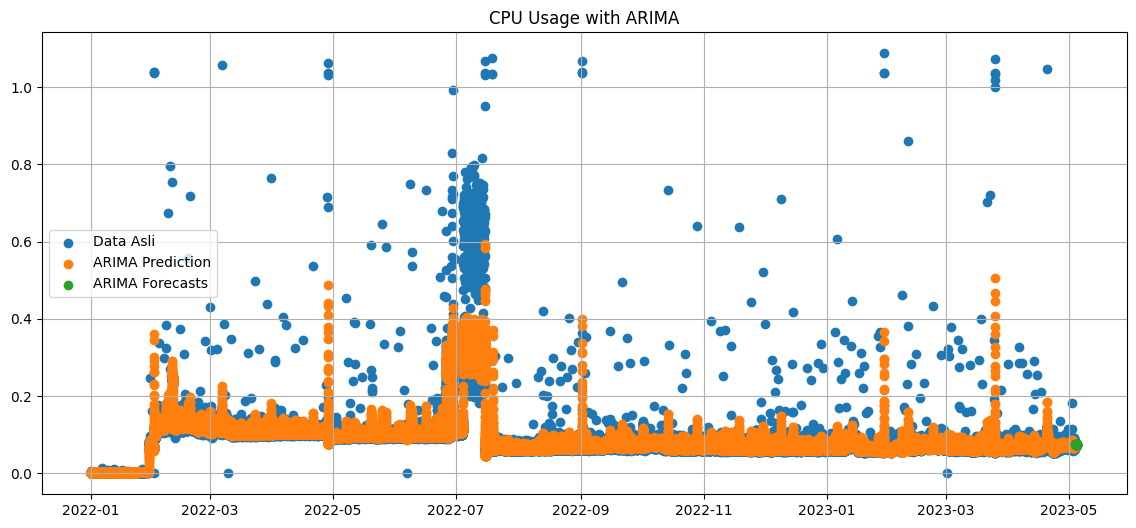

In [89]:
fig, ax = plt.subplots(1,1,figsize=(14,6))

ax.scatter(full_data["created_at"], 
           full_data["cpu_used"], 
           label='Data Asli')

ax.scatter(full_data["created_at"], 
           fitting, 
           label='ARIMA Prediction')

ax.scatter(predictions['Timestamp'], 
           predictions['Prediction'], 
           label='ARIMA Forecasts')

plt.title('CPU Usage with ARIMA')
plt.grid()
plt.legend()

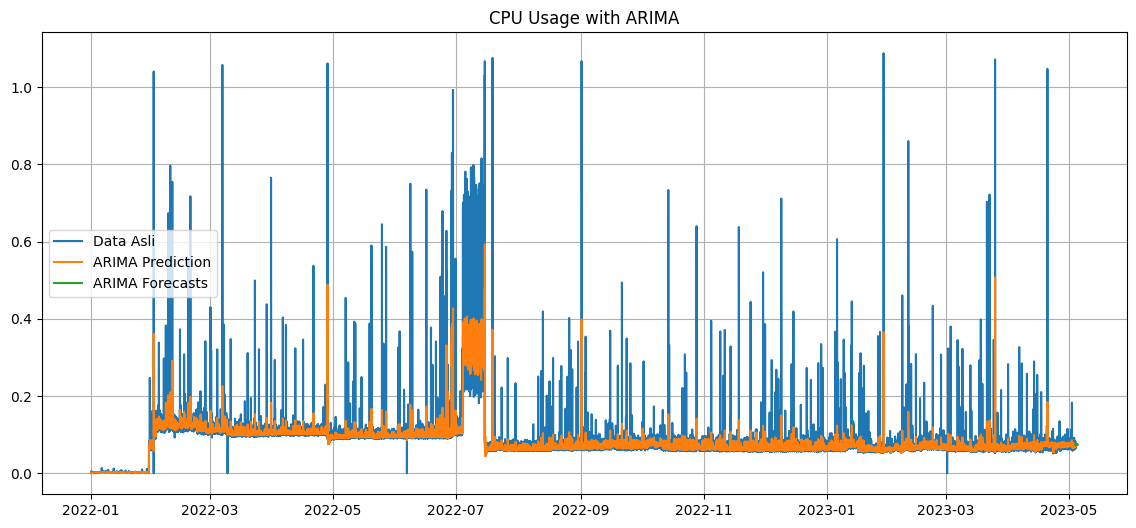

In [90]:
fig, ax = plt.subplots(1,1,figsize=(14,6))

ax.plot(full_data["created_at"], 
           full_data["cpu_used"], 
           label='Data Asli')

ax.plot(full_data["created_at"], 
           fitting, 
           label='ARIMA Prediction')

ax.plot(predictions['Timestamp'], 
           predictions['Prediction'], 
           label='ARIMA Forecasts')

plt.title('CPU Usage with ARIMA')
plt.grid()
plt.legend()

## Additional Resource Prediction

In [91]:
# Search for CPU Usage percentages that are equal or more than 80%
need_add = predictions[predictions['Prediction'] >= 0.07474]
need_add['Prediction'] = (need_add['Prediction']*100).round(4)
need_add['Prediction'] = need_add['Prediction'].astype(str) + '%'

if need_add.empty:
  print(f"Your forecasted CPU Usage value in 30 days ahead will be {predictions['Prediction'].iloc[-1] * 100:.4f}%")
else:
  print("Based on your usage pattern, you will reach more than 80% of your current available CPU core!")
  print(need_add)

Based on your usage pattern, you will reach more than 80% of your current available CPU core!
                 Timestamp Prediction
140353 2023-05-04 04:25:00    7.4747%
140355 2023-05-04 06:25:00    7.4744%
140357 2023-05-04 08:25:00    7.4742%


In [92]:
import pickle
pickle.dump(need_add, open('additional.pkl', 'wb'))

## Anomaly Detection

In [93]:
df_dummy = full_data.copy()
df_dummy["fittings"] = fitting
df_dummy['Error'] = df_dummy['cpu_used'] - df_dummy['fittings']
df_dummy

,created_at,cpu_used,fittings,Error
0,2022-01-01 00:00:00,0.0020,0.000000,2.000000e-03
1,2022-01-01 00:05:00,0.0020,0.002000,1.049911e-12
2,2022-01-01 00:10:00,0.0019,0.002000,-1.000000e-04
3,2022-01-01 00:15:00,0.0020,0.001968,3.243695e-05
4,2022-01-01 00:20:00,0.0020,0.001973,2.716225e-05
...,...,...,...,...
140348,2023-05-04 03:05:00,0.0685,0.073231,-4.731247e-03
140349,2023-05-04 03:10:00,0.0743,0.074381,-8.143635e-05
140350,2023-05-04 03:15:00,0.0773,0.072634,4.665599e-03
140351,2023-05-04 03:20:00,0.0724,0.074888,-2.487859e-03


In [94]:
df_dummy.to_csv('anomaly.csv', index=False)

In [95]:
import pickle
pickle.dump(df_dummy, open('anomaly.pkl', 'wb'))

Text(0.5, 1.0, 'Residual Error')

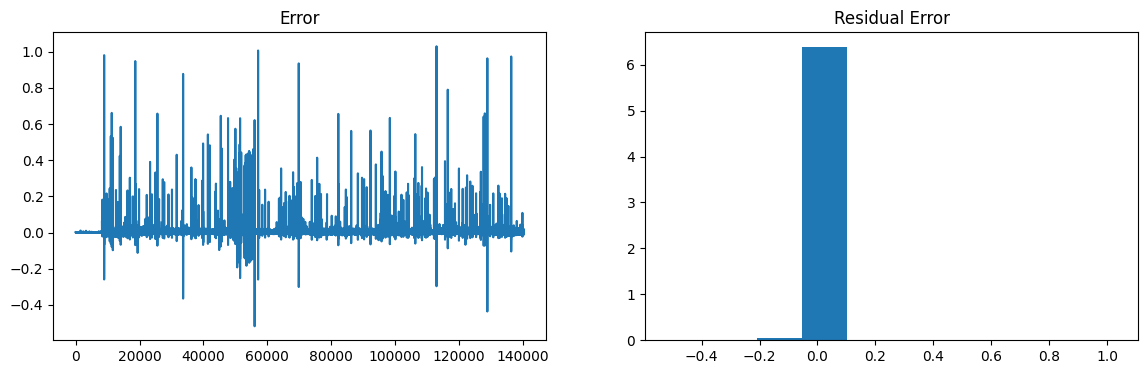

In [32]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,4))
ax1.plot(model_fit.resid)
ax1.set_title('Error')
ax2.hist(model_fit.resid, density=True)
ax2.set_title('Residual Error')

In [33]:
model_fit.resid.skew()

15.109826267618937

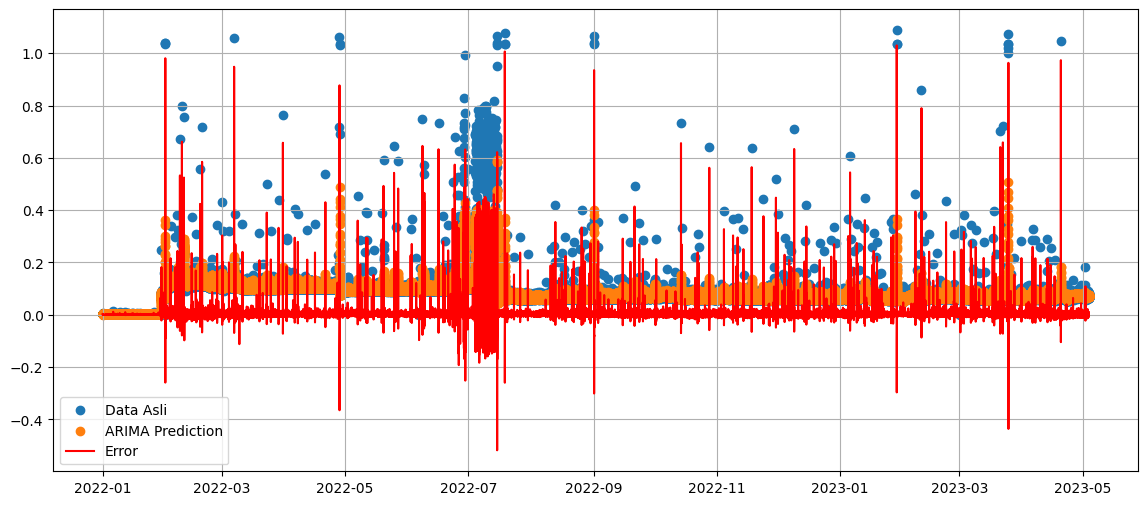

In [34]:
fig, ax = plt.subplots(1,1,figsize=(14,6))
ax.scatter(df_dummy['created_at'], df_dummy['cpu_used'], label='Data Asli')
ax.scatter(df_dummy['created_at'], df_dummy['fittings'], label='ARIMA Prediction')
ax.plot(df_dummy['created_at'], df_dummy['Error'], c='red', label='Error')
plt.grid()
plt.legend()

### Static Thresholding: Z-Score

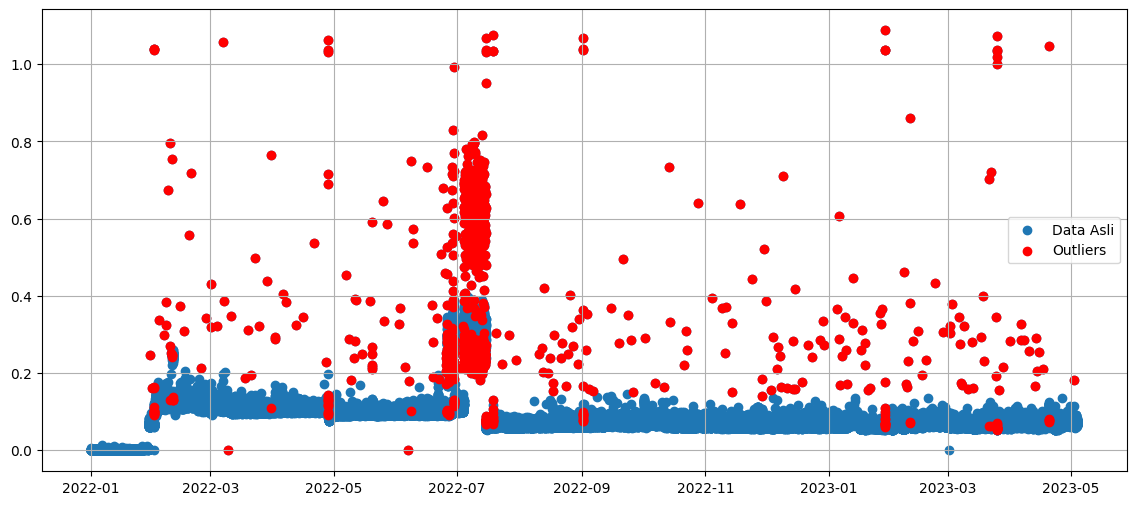

In [35]:
# Menggunakan Z-Score dengan batas 3 std

up_stat_thres = df_dummy['Error'].mean() + (3 * df_dummy['Error'].std())
down_stat_thres = df_dummy['Error'].mean() - (3 * df_dummy['Error'].std())
out_index = df_dummy.index[(df_dummy['Error'] > up_stat_thres) | (df_dummy['Error'] < down_stat_thres)]

fig, ax = plt.subplots(1,1,figsize=(14,6))
ax.scatter(df_dummy['created_at'], df_dummy['cpu_used'], label='Data Asli')
ax.scatter(df_dummy['created_at'][out_index], df_dummy['cpu_used'][out_index], c='Red', label='Outliers')
plt.grid()
plt.legend()

### Static Thresholding: IQR

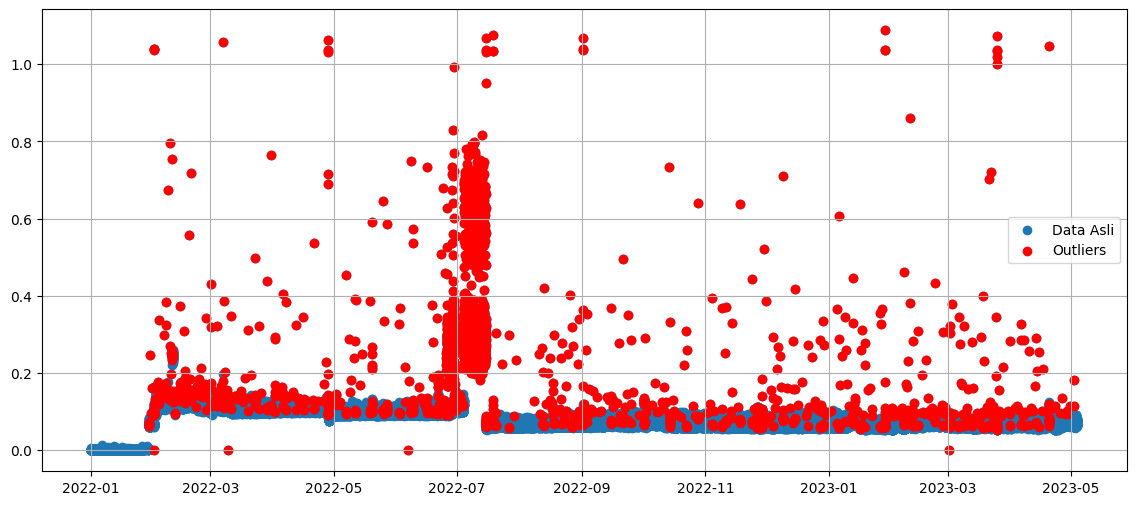

In [36]:
# Menggunakan Tukey's Fence dengan batas 10 Interquartile Range (IQR)

IQR = df_dummy['Error'].quantile(0.75) - df_dummy['Error'].quantile(0.25)
up_stat_thres = df_dummy['Error'].quantile(0.75) + (5*IQR)
down_stat_thres = df_dummy['Error'].quantile(0.25) - (5*IQR)
out_index = df_dummy.index[(df_dummy['Error'] > up_stat_thres) | (df_dummy['Error'] < down_stat_thres)]

fig, ax = plt.subplots(1,1,figsize=(14,6))
ax.scatter(df_dummy['created_at'], df_dummy['cpu_used'], label='Data Asli')
ax.scatter(df_dummy['created_at'][out_index], df_dummy['cpu_used'][out_index], c='Red', label='Outliers')
plt.grid()
plt.legend()

### Dynamic Thresholding

Menariknya, dengan adanya informasi error residual setiap titik data terhadap prediksi ARIMA, maka threshold outliers yang digunakan juga dapat bersifat dinamis. Nilai mean yang digunakan untuk mengukur batas atas dan bawah outliers tidak perlu harus mean global dataset, namun dapat berupa mean lokal dengan time window tertentu, seperti mean 1 hari terakhir, 2 minggu terakhir, 1 bulan terakhir, dsb. Teknik ini dapat membuat pendeteksian outliers menjadi semakin sensitif dalam menyesuaikan diri dengan trend lokal data penggunaan CPU.

In [37]:
df_copy = df_dummy.copy()
std_coef = 5  # Besar standar deviasi penyimpangan dari mean window
window = int(7*24*12)  # Window 7 Hari

df_copy['mean'] = pd.Series(df_copy['Error'].rolling(window=window).mean())
df_copy['std'] = pd.Series(df_copy['Error'].rolling(window=window).std())
df_copy['up_thres'] = pd.Series(df_copy['Error'].rolling(window=window).mean()) \
                    + (std_coef * pd.Series(df_copy['Error'].rolling(window=window).std()))

df_copy['down_thres'] = pd.Series(df_copy['Error'].rolling(window=window).mean()) \
                    - (std_coef * pd.Series(df_copy['Error'].rolling(window=window).std()))

out_index = df_copy.index[(df_copy['Error'] > df_copy['up_thres']) | (df_copy['Error'] < df_copy['down_thres'])]

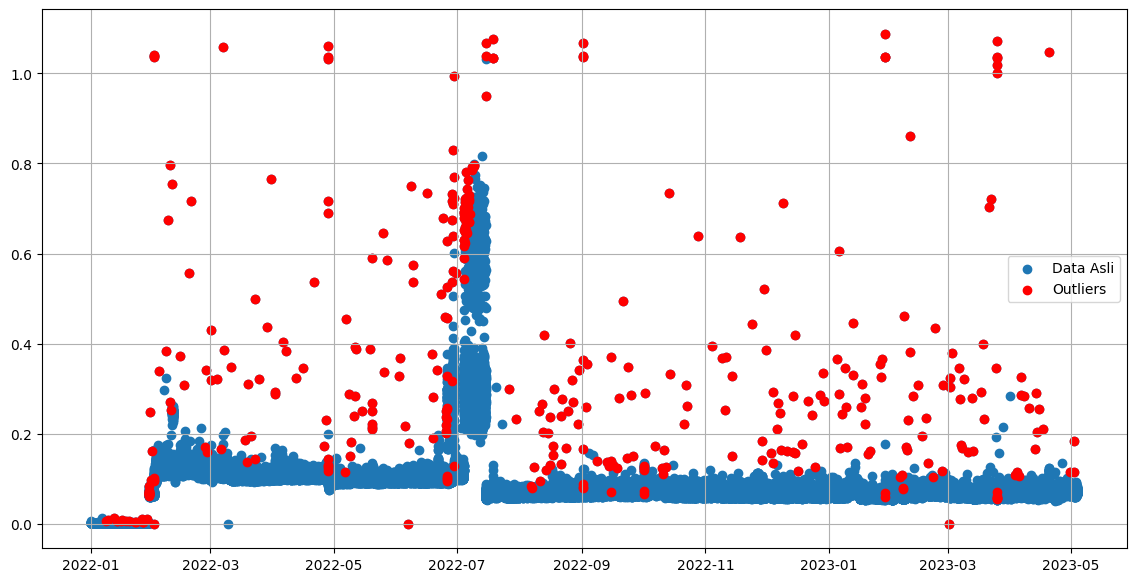

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
ax.scatter(df_copy['created_at'], df_copy['cpu_used'], label='Data Asli')
ax.scatter(df_copy['created_at'][out_index], df_copy['cpu_used'][out_index], c='Red', label='Outliers')
plt.grid()
plt.legend()

### Dynamic Thresholding + Consecutive Occurences

In [39]:
data_copy = df_dummy.copy()
std_coef = 1.5  # Besar standar deviasi penyimpangan dari mean window
window = int(90*24*12)  # Windowing
consecutive = 3  # Frekuensi minimum kemunculan outliers berturut-turut

data_copy['mean'] = pd.Series(data_copy['Error'].rolling(window=window).mean())
data_copy['std'] = pd.Series(data_copy['Error'].rolling(window=window).std())
data_copy['up_thres'] = pd.Series(data_copy['Error'].rolling(window=window).mean()) \
                    + (std_coef * pd.Series(data_copy['Error'].rolling(window=window).std()))
data_copy['down_thres'] = pd.Series(data_copy['Error'].rolling(window=window).mean()) \
                    - (std_coef * pd.Series(data_copy['Error'].rolling(window=window).std()))

out_index = data_copy.index[(data_copy['Error'] > data_copy['up_thres']) | (data_copy['Error'] < data_copy['down_thres'])]

data_copy['outliers_bool'] = [False for _ in range(len(data_copy))]
data_copy['outliers_bool'][out_index] = True

In [40]:
greater_th = [list(g) for k, g in groupby(data_copy['outliers_bool']==True)]

for i in range(len(greater_th)):
  if greater_th[i].count(True) < consecutive:
    greater_th[i] = [False for _ in greater_th[i]]

greater_th = pd.DataFrame({"Outliers": [element for sublist in greater_th for element in sublist]})
updated_out_index = greater_th[greater_th["Outliers"]==True].index

In [41]:
print(f"Jumlah Outliers: {len(updated_out_index)}")
updated_out_index

Jumlah Outliers: 1800


Int64Index([ 27279,  27280,  27281,  27720,  27721,  27722,  30158,  30159,
             30160,  31635,
            ...
            136357, 136358, 136359, 136360, 136361, 136362, 136363, 136364,
            136365, 136366],
           dtype='int64', length=1800)

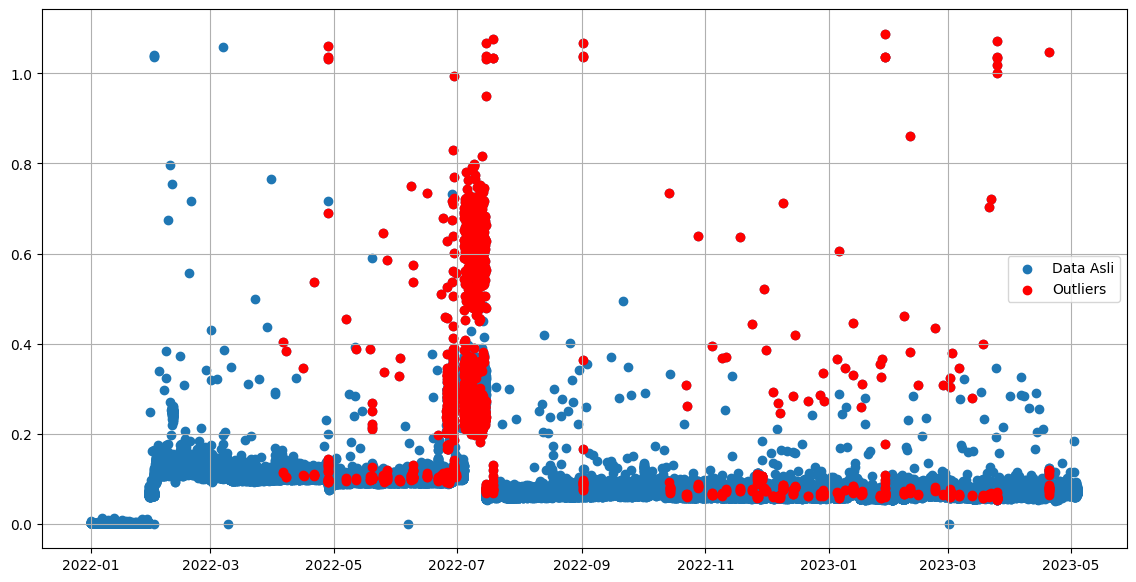

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
ax.scatter(data_copy['created_at'], data_copy['cpu_used'], label='Data Asli')
ax.scatter(data_copy['created_at'][updated_out_index], data_copy['cpu_used'][updated_out_index], c='Red', label='Outliers')
plt.grid()
plt.legend()

### Playground

In [43]:
data_copy.iloc[updated_out_index, ::12]

,created_at
27279,2022-04-06 02:40:00
27280,2022-04-06 02:45:00
27281,2022-04-06 02:50:00
27720,2022-04-07 15:30:00
27721,2022-04-07 15:35:00
...,...
136362,2023-04-20 06:55:00
136363,2023-04-20 07:00:00
136364,2023-04-20 07:05:00
136365,2023-04-20 07:10:00


In [ ]:
predictions.to_csv('predictions.csv', index=False)

In [44]:
data_copy.iloc[::12]

,created_at,cpu_used,fittings,Error,mean,std,up_thres,down_thres,outliers_bool
0,2022-01-01 00:00:00,0.0020,0.000000,0.002000,NaN,NaN,NaN,NaN,False
12,2022-01-01 01:00:00,0.0020,0.001910,0.000090,NaN,NaN,NaN,NaN,False
24,2022-01-01 02:00:00,0.0019,0.001950,-0.000050,NaN,NaN,NaN,NaN,False
36,2022-01-01 03:00:00,0.0019,0.001923,-0.000023,NaN,NaN,NaN,NaN,False
48,2022-01-01 04:00:00,0.0020,0.001915,0.000085,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...
140304,2023-05-03 23:25:00,0.0700,0.072295,-0.002295,0.000003,0.018633,0.027952,-0.027946,False
140316,2023-05-04 00:25:00,0.0673,0.070631,-0.003331,0.000003,0.018633,0.027952,-0.027947,False
140328,2023-05-04 01:25:00,0.0702,0.069140,0.001060,0.000002,0.018633,0.027952,-0.027947,False
140340,2023-05-04 02:25:00,0.0723,0.069244,0.003056,0.000003,0.018633,0.027952,-0.027947,False


In [45]:
predictions['package_id'] = '2'
predictions.iloc[::12]

,Timestamp,Prediction,package_id
140353,2023-05-04 03:30:00,0.074747,2
140365,2023-05-04 04:30:00,0.074730,2
140377,2023-05-04 05:30:00,0.074712,2
140389,2023-05-04 06:30:00,0.074695,2
140401,2023-05-04 07:30:00,0.074678,2
...,...,...,...
148933,2023-06-02 22:30:00,0.073943,2
148945,2023-06-02 23:30:00,0.073943,2
148957,2023-06-03 00:30:00,0.073943,2
148969,2023-06-03 01:30:00,0.073943,2


In [46]:
conditions = [
    (predictions['Prediction'] >= 0.80) & (predictions['package_id'] == 1),
    (predictions['Prediction'] <= 0.80) & (predictions['package_id'] == 1),
    (predictions['Prediction'] >= 0.80) & (predictions['package_id'] == 2),
    (predictions['Prediction'] <= 0.80) & (predictions['package_id'] == 2),
    (predictions['Prediction'] >= 0.80) & (predictions['package_id'] == 4),
    (predictions['Prediction'] <= 0.80) & (predictions['package_id'] == 4),
    (predictions['Prediction'] >= 0.80) & (predictions['package_id'] == 6),
    (predictions['Prediction'] <= 0.80) & (predictions['package_id'] == 6),
    (predictions['Prediction'] >= 0.80) & (predictions['package_id'] == 8),
    (predictions['Prediction'] <= 0.80) & (predictions['package_id'] == 8)
]

choices = [
    np.where(conditions[0], 277, 0),
    np.where(conditions[1], 118, 0),
    np.where(conditions[2], 972, 0),
    np.where(conditions[3], 277, 0),
    np.where(conditions[4], 1000, 0),
    np.where(conditions[5], 972, 0),
    np.where(conditions[6], 2083, 0),
    np.where(conditions[7], 1000, 0),
    np.where(conditions[8], 2986, 0),
    np.where(conditions[9], 2083, 0)
]

predictions['cost'] = np.sum(choices, axis=0)

In [50]:
predictions['package_id'] = predictions['package_id'].astype('int64')

In [51]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 140353 to 148992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Timestamp   8640 non-null   datetime64[ns]
 1   Prediction  8640 non-null   float64       
 2   package_id  8640 non-null   int64         
 3   cost        8640 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 270.1 KB


In [54]:
predictions.iloc[::12]

,Timestamp,Prediction,package_id,cost
140353,2023-05-04 03:30:00,0.074747,2,0
140365,2023-05-04 04:30:00,0.074730,2,0
140377,2023-05-04 05:30:00,0.074712,2,0
140389,2023-05-04 06:30:00,0.074695,2,0
140401,2023-05-04 07:30:00,0.074678,2,0
...,...,...,...,...
148933,2023-06-02 22:30:00,0.073943,2,0
148945,2023-06-02 23:30:00,0.073943,2,0
148957,2023-06-03 00:30:00,0.073943,2,0
148969,2023-06-03 01:30:00,0.073943,2,0
